## 주거타입별 예측 모델

In [1]:
# -*- coding:utf-8 -*-
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet

total_df = pd.read_csv("data/seoul_real_estate.csv")
total_df['DEAL_YMD'] = pd.to_datetime(total_df['DEAL_YMD'], format="%Y-%m-%d")
types = list(total_df['HOUSE_TYPE'].unique())
print(types)
periods = 28

['단독다가구', '아파트', '오피스텔', '연립다세대']


C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = Prophet()
total_df2 = total_df.loc[total_df['HOUSE_TYPE'] == types[0], ["DEAL_YMD", "OBJ_AMT"]]
result_df = total_df2.groupby('DEAL_YMD')['OBJ_AMT'].agg("mean").reset_index()
result_df = result_df.rename(columns={"DEAL_YMD": "ds", "OBJ_AMT": "y"})
model.fit(result_df)
future = model.make_future_dataframe(periods=periods)
forecast = model.predict(future)
forecast.tail()

11:22:45 - cmdstanpy - INFO - Chain [1] start processing
11:22:46 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
89,2023-05-28,98567.002538,-22987.877212,108385.777302,98566.998815,98567.006173,-54568.087492,-54568.087492,-54568.087492,-54568.087492,-54568.087492,-54568.087492,0.0,0.0,0.0,43998.915046
90,2023-05-29,98022.444605,25567.096781,163038.372393,98022.440598,98022.448441,-6520.760565,-6520.760565,-6520.760565,-6520.760565,-6520.760565,-6520.760565,0.0,0.0,0.0,91501.684040
91,2023-05-30,97477.886671,46452.807489,180034.080096,97477.882439,97477.890750,15589.745703,15589.745703,15589.745703,15589.745703,15589.745703,15589.745703,0.0,0.0,0.0,113067.632375
92,2023-05-31,96933.328738,34553.786159,166440.036589,96933.324252,96933.333055,3545.606926,3545.606926,3545.606926,3545.606926,3545.606926,3545.606926,0.0,0.0,0.0,100478.935663
93,2023-06-01,96388.770804,21808.054935,160407.186251,96388.766088,96388.775356,-2956.095007,-2956.095007,-2956.095007,-2956.095007,-2956.095007,-2956.095007,0.0,0.0,0.0,93432.675797


11:22:46 - cmdstanpy - INFO - Chain [1] start processing
11:22:46 - cmdstanpy - INFO - Chain [1] done processing
11:22:46 - cmdstanpy - INFO - Chain [1] start processing
11:22:47 - cmdstanpy - INFO - Chain [1] done processing
11:22:47 - cmdstanpy - INFO - Chain [1] start processing
11:22:47 - cmdstanpy - INFO - Chain [1] done processing
11:22:48 - cmdstanpy - INFO - Chain [1] start processing
11:22:48 - cmdstanpy - INFO - Chain [1] done processing


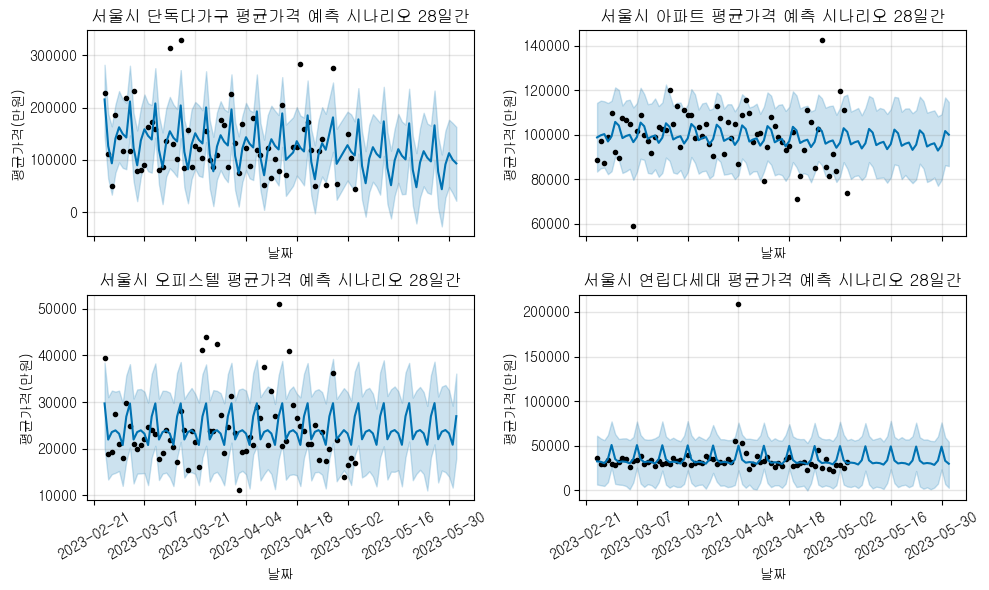

In [3]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

fig, ax = plt.subplots(figsize=(10, 6), sharex=True, ncols=2, nrows=2)
for i in range(0, len(types)):
    model = Prophet()
    total_df2 = total_df.loc[total_df['HOUSE_TYPE'] == types[i], ["DEAL_YMD", "OBJ_AMT"]]
    result_df = total_df2.groupby('DEAL_YMD')['OBJ_AMT'].agg("mean").reset_index()
    result_df = result_df.rename(columns={"DEAL_YMD": "ds", "OBJ_AMT": "y"})
    model.fit(result_df)
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    if i <= 1:
        fig = model.plot(forecast, uncertainty=True, ax=ax[0, i])
        ax[0, i].set_title(f"서울시 {types[i]} 평균가격 예측 시나리오 {periods}일간")
        ax[0, i].set_xlabel(f"날짜")
        ax[0, i].set_ylabel(f"평균가격(만원)")
        for tick in ax[0, i].get_xticklabels():
            tick.set_rotation(30)
    else:
        fig = model.plot(forecast, uncertainty=True, ax=ax[1, i-2])
        ax[1, i-2].set_title(f"서울시 {types[i]} 평균가격 예측 시나리오 {periods}일간")
        ax[1, i-2].set_xlabel(f"날짜")
        ax[1, i-2].set_ylabel(f"평균가격(만원)")
        for tick in ax[1, i-2].get_xticklabels():
            tick.set_rotation(30)
            
plt.tight_layout()
plt.savefig('output/ml01.png', dpi=200)
plt.show()

## 예측 모델 지역구별로 저장

In [4]:
import matplotlib.pyplot as plt
import streamlit as st
import pandas as pd
from prophet import Prophet
from prophet.serialize import model_to_json
import json

total_df = pd.read_csv("data/seoul_real_estate.csv")
total_df['DEAL_YMD'] = pd.to_datetime(total_df['DEAL_YMD'], format="%Y-%m-%d")
total_df = total_df[total_df['HOUSE_TYPE'] == "아파트"]

sgg_nms = sorted(list(total_df['SGG_NM'].unique()))
periods = 28
for sgg_nm in sgg_nms:
    model = Prophet()
    total_df2 = total_df.loc[total_df['SGG_NM'] == sgg_nm, ["DEAL_YMD", "OBJ_AMT"]]
    summary_df = total_df2.groupby('DEAL_YMD')['OBJ_AMT'].agg("mean").reset_index()
    summary_df = summary_df.rename(columns={"DEAL_YMD": "ds", "OBJ_AMT": "y"})
    model.fit(summary_df)
    
    with open(f'ml/models/{sgg_nm}_model.json', 'w') as fout:
        json.dump(model_to_json(model), fout)  # Save model

11:22:51 - cmdstanpy - INFO - Chain [1] start processing
11:22:51 - cmdstanpy - INFO - Chain [1] done processing
11:22:51 - cmdstanpy - INFO - Chain [1] start processing
11:22:51 - cmdstanpy - INFO - Chain [1] done processing
11:22:51 - cmdstanpy - INFO - Chain [1] start processing
11:22:51 - cmdstanpy - INFO - Chain [1] done processing
11:22:52 - cmdstanpy - INFO - Chain [1] start processing
11:22:52 - cmdstanpy - INFO - Chain [1] done processing
11:22:52 - cmdstanpy - INFO - Chain [1] start processing
11:22:52 - cmdstanpy - INFO - Chain [1] done processing
11:22:52 - cmdstanpy - INFO - Chain [1] start processing
11:22:52 - cmdstanpy - INFO - Chain [1] done processing
11:22:53 - cmdstanpy - INFO - Chain [1] start processing
11:22:53 - cmdstanpy - INFO - Chain [1] done processing
11:22:53 - cmdstanpy - INFO - Chain [1] start processing
11:22:53 - cmdstanpy - INFO - Chain [1] done processing
11:22:53 - cmdstanpy - INFO - Chain [1] start processing
11:22:53 - cmdstanpy - INFO - Chain [1]

## 저장된 예측 모형 불러오기

In [5]:
import json 
from prophet.serialize import model_from_json

models = [] 
for sgg_nm in sgg_nms:
    print(sgg_nm)
    with open(f'ml/models/{sgg_nm}_model.json', 'r') as fin:
        model = model_from_json(json.load(fin))  # Load model
    models.append(model)
models

C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


강남구
강동구


C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


강북구
강서구


C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


관악구
광진구


C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


구로구
금천구


C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


노원구
도봉구


C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


동대문구
동작구


C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


마포구
서대문구


C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


서초구
성동구


C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


성북구
송파구


C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


양천구
영등포구


C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


용산구
은평구


C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


종로구
중구


C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


중랑구


C:\Users\YONSAI\Documents\streamlitbook-evansarah\venv\lib\site-packages\prophet\serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


In [10]:
future = models[0].make_future_dataframe(periods=periods)
forecast = models[0].predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
82,2023-05-27,285081.490559,191352.401899,376381.382362,285081.485002,285081.496306,-3340.825073,-3340.825073,-3340.825073,-3340.825073,-3340.825073,-3340.825073,0.0,0.0,0.0,281740.665486
83,2023-05-28,286249.536500,202872.775417,372060.311994,286249.530618,286249.542571,257.779488,257.779488,257.779488,257.779488,257.779488,257.779488,0.0,0.0,0.0,286507.315988
84,2023-05-29,287417.582441,208032.162438,386185.646071,287417.576220,287417.588789,10790.611764,10790.611764,10790.611764,10790.611764,10790.611764,10790.611764,0.0,0.0,0.0,298208.194206
85,2023-05-30,288585.628383,182520.844884,356129.751782,288585.621753,288585.635171,-20868.262753,-20868.262753,-20868.262753,-20868.262753,-20868.262753,-20868.262753,0.0,0.0,0.0,267717.365629
86,2023-05-31,289753.674324,186939.818322,366536.692769,289753.667277,289753.681567,-11161.293367,-11161.293367,-11161.293367,-11161.293367,-11161.293367,-11161.293367,0.0,0.0,0.0,278592.380956


In [12]:
future = models[1].make_future_dataframe(periods=periods)
forecast = models[1].predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
87,2023-05-26,104307.625968,90411.675336,136307.902261,104306.218857,104308.950643,9093.691542,9093.691542,9093.691542,9093.691542,9093.691542,9093.691542,0.0,0.0,0.0,113401.317510
88,2023-05-27,104395.949121,82717.222834,124841.711014,104394.445277,104397.359607,-286.648145,-286.648145,-286.648145,-286.648145,-286.648145,-286.648145,0.0,0.0,0.0,104109.300976
89,2023-05-28,104484.272274,88406.804481,133766.862287,104482.677140,104485.791361,7254.459936,7254.459936,7254.459936,7254.459936,7254.459936,7254.459936,0.0,0.0,0.0,111738.732209
90,2023-05-29,104572.595427,78911.918992,122200.144523,104570.922383,104574.201609,-4726.644450,-4726.644450,-4726.644450,-4726.644450,-4726.644450,-4726.644450,0.0,0.0,0.0,99845.950976
91,2023-05-30,104660.918580,91252.253367,135920.079814,104659.151478,104662.651629,8797.525161,8797.525161,8797.525161,8797.525161,8797.525161,8797.525161,0.0,0.0,0.0,113458.443741


강남구
강동구
강북구
강서구
관악구
광진구
구로구
금천구
노원구
도봉구
동대문구
동작구
마포구
서대문구
서초구
성동구
성북구
송파구
양천구
영등포구
용산구
은평구
종로구
중구
중랑구


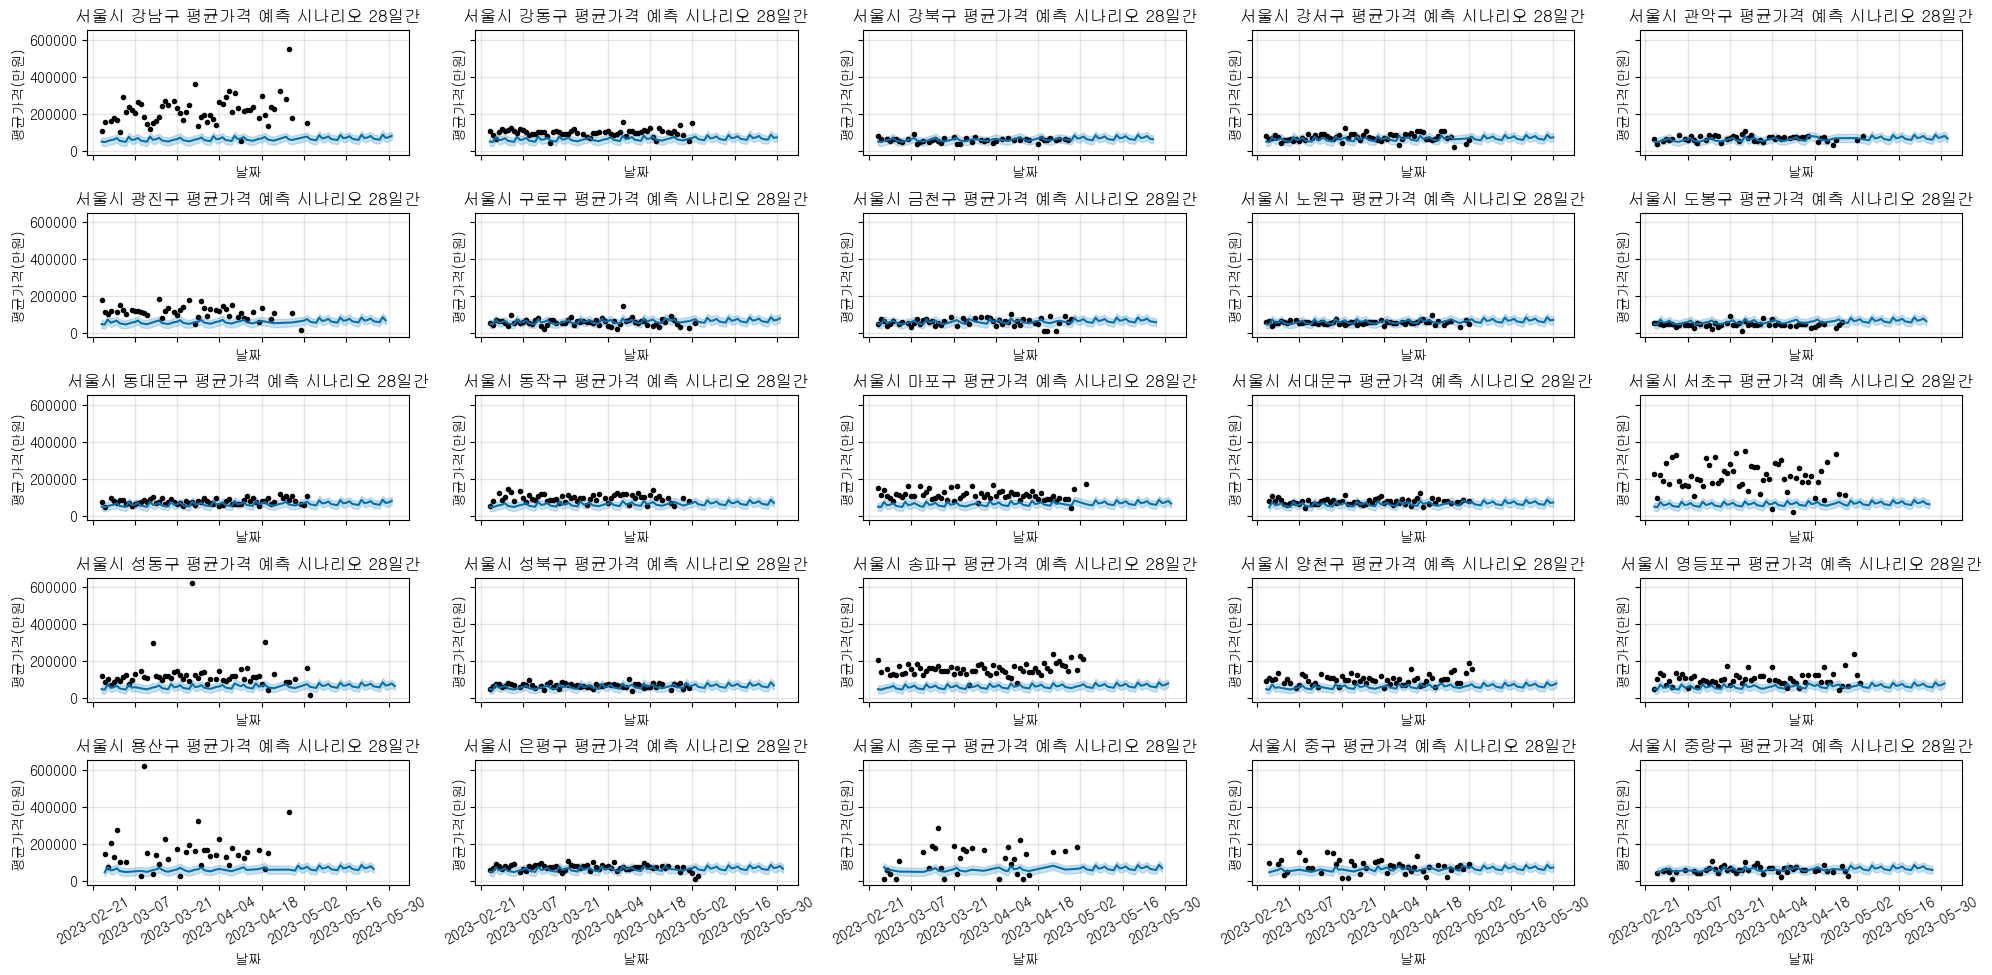

In [8]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
periods = 28
fig, ax = plt.subplots(figsize=(20, 10), sharex=True, sharey=True, ncols=5, nrows=5)
for i in range(0, len(sgg_nms)):
    future = models[i].make_future_dataframe(periods=periods)
    forecast = models[i].predict(future)
    print(sgg_nms[i])
    if i <= 4:

        fig = models[i].plot(forecast, uncertainty=True, ax=ax[0, i])
        ax[0, i].set_title(f"서울시 {sgg_nms[i]} 평균가격 예측 시나리오 {periods}일간")
        ax[0, i].set_xlabel(f"날짜")
        ax[0, i].set_ylabel(f"평균가격(만원)")
        for tick in ax[0, i].get_xticklabels():
            tick.set_rotation(30)
    elif i <= 9:

        fig = models[i].plot(forecast, uncertainty=True, ax=ax[1, i-5])
        ax[1, i-5].set_title(f"서울시 {sgg_nms[i]} 평균가격 예측 시나리오 {periods}일간")
        ax[1, i-5].set_xlabel(f"날짜")
        ax[1, i-5].set_ylabel(f"평균가격(만원)")
        for tick in ax[1, i-5].get_xticklabels():
            tick.set_rotation(30)
    elif i <= 14:

        fig = models[i].plot(forecast, uncertainty=True, ax=ax[2, i-10])
        ax[2, i-10].set_title(f"서울시 {sgg_nms[i]} 평균가격 예측 시나리오 {periods}일간")
        ax[2, i-10].set_xlabel(f"날짜")
        ax[2, i-10].set_ylabel(f"평균가격(만원)")
        for tick in ax[2, i-10].get_xticklabels():
            tick.set_rotation(30)
    elif i <= 19:

        fig = models[i].plot(forecast, uncertainty=True, ax=ax[3, i-15])
        ax[3, i-15].set_title(f"서울시 {sgg_nms[i]} 평균가격 예측 시나리오 {periods}일간")
        ax[3, i-15].set_xlabel(f"날짜")
        ax[3, i-15].set_ylabel(f"평균가격(만원)")
        for tick in ax[3, i-15].get_xticklabels():
            tick.set_rotation(30)
    elif i <= 24:

        fig = models[i].plot(forecast, uncertainty=True, ax=ax[4, i-20])
        ax[4, i-20].set_title(f"서울시 {sgg_nms[i]} 평균가격 예측 시나리오 {periods}일간")
        ax[4, i-20].set_xlabel(f"날짜")
        ax[4, i-20].set_ylabel(f"평균가격(만원)")
        for tick in ax[4, i-20].get_xticklabels():
            tick.set_rotation(30)
    else:
        pass 
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig('output/ml02.png', dpi=200)
plt.show()

강남구
강동구
강북구
강서구
관악구
광진구
구로구
금천구
노원구
도봉구
동대문구
동작구
마포구
서대문구
서초구
성동구
성북구
송파구
양천구
영등포구
용산구
은평구
종로구
중구
중랑구


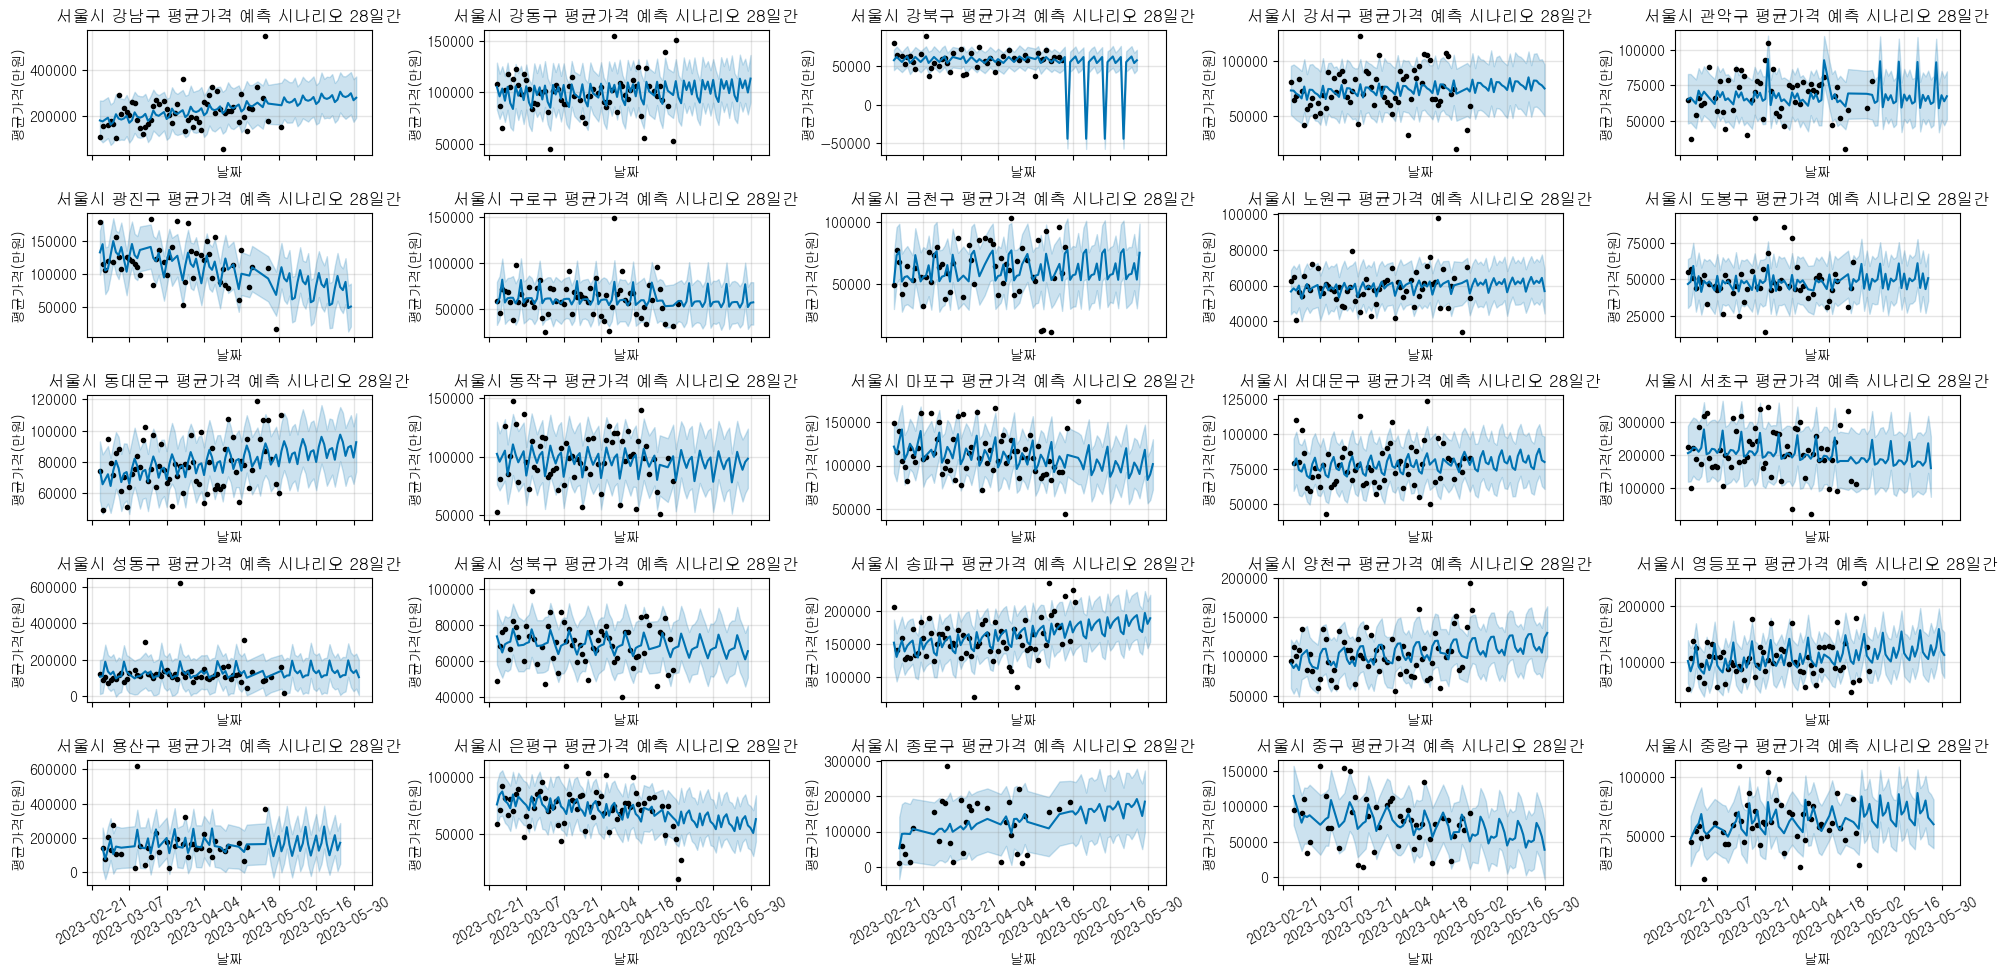

In [9]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
periods = 28
fig, ax = plt.subplots(figsize=(20, 10), sharex=True, sharey=False, ncols=5, nrows=5)
for i in range(0, len(sgg_nms)):
    future1 = models[i].make_future_dataframe(periods=periods)
    forecast1 = models[i].predict(future1)
    print(sgg_nms[i])
    if i <= 4:

        fig = models[i].plot(forecast1, uncertainty=True, ax=ax[0, i])
        ax[0, i].set_title(f"서울시 {sgg_nms[i]} 평균가격 예측 시나리오 {periods}일간")
        ax[0, i].set_xlabel(f"날짜")
        ax[0, i].set_ylabel(f"평균가격(만원)")
        for tick in ax[0, i].get_xticklabels():
            tick.set_rotation(30)
    elif i <= 9:

        fig = models[i].plot(forecast1, uncertainty=True, ax=ax[1, i-5])
        ax[1, i-5].set_title(f"서울시 {sgg_nms[i]} 평균가격 예측 시나리오 {periods}일간")
        ax[1, i-5].set_xlabel(f"날짜")
        ax[1, i-5].set_ylabel(f"평균가격(만원)")
        for tick in ax[1, i-5].get_xticklabels():
            tick.set_rotation(30)
    elif i <= 14:

        fig = models[i].plot(forecast1, uncertainty=True, ax=ax[2, i-10])
        ax[2, i-10].set_title(f"서울시 {sgg_nms[i]} 평균가격 예측 시나리오 {periods}일간")
        ax[2, i-10].set_xlabel(f"날짜")
        ax[2, i-10].set_ylabel(f"평균가격(만원)")
        for tick in ax[2, i-10].get_xticklabels():
            tick.set_rotation(30)
    elif i <= 19:

        fig = models[i].plot(forecast1, uncertainty=True, ax=ax[3, i-15])
        ax[3, i-15].set_title(f"서울시 {sgg_nms[i]} 평균가격 예측 시나리오 {periods}일간")
        ax[3, i-15].set_xlabel(f"날짜")
        ax[3, i-15].set_ylabel(f"평균가격(만원)")
        for tick in ax[3, i-15].get_xticklabels():
            tick.set_rotation(30)
    elif i <= 24:

        fig = models[i].plot(forecast1, uncertainty=True, ax=ax[4, i-20])
        ax[4, i-20].set_title(f"서울시 {sgg_nms[i]} 평균가격 예측 시나리오 {periods}일간")
        ax[4, i-20].set_xlabel(f"날짜")
        ax[4, i-20].set_ylabel(f"평균가격(만원)")
        for tick in ax[4, i-20].get_xticklabels():
            tick.set_rotation(30)
    else:
        pass 
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig('output/ml03.png', dpi=200)
plt.show()